In [1]:
%use adventOfCode

In [2]:
val puzzle = AocClient.fromEnv().interactiveDay(2024, 14)
puzzle.viewPartOne()

--- Day 14: Restroom Redoubt --- 
 One of The Historians needs to use the bathroom; fortunately, you know there's a bathroom near an unvisited location on their list, and so you're all quickly teleported directly to the lobby of Easter Bunny Headquarters. 
 Unfortunately, EBHQ seems to have "improved" bathroom security again after your last visit . The area outside the bathroom is swarming with robots! 
 To get The Historian safely to the bathroom, you'll need a way to predict where the robots will be in the future. Fortunately, they all seem to be moving on the tile floor in predictable straight lines . 
 You make a list (your puzzle input) of all of the robots' current positions ( p ) and velocities ( v ), one robot per line. For example: 
 p=0,4 v=3,-3
p=6,3 v=-1,-3
p=10,3 v=-1,2
p=2,0 v=2,-1
p=0,0 v=1,3
p=3,0 v=-2,-2
p=7,6 v=-1,-3
p=3,0 v=-1,-2
p=9,3 v=2,3
p=7,3 v=-1,2
p=2,4 v=2,-3
p=9,5 v=-3,-3
 
 Each robot's position is given as p=x,y where x represents the number of tiles the robot is from the left wall and y represents the number of tiles from the top wall (when viewed from above). So, a position of p=0,0 means the robot is all the way in the top-left corner. 
 Each robot's velocity is given as v=x,y where x and y are given in tiles per second . Positive x means the robot is moving to the right , and positive y means the robot is moving down . So, a velocity of v=1,-2 means that each second, the robot moves 1 tile to the right and 2 tiles up. 
 The robots outside the actual bathroom are in a space which is 101 tiles wide and 103 tiles tall (when viewed from above). However, in this example, the robots are in a space which is only 11 tiles wide and 7 tiles tall. 
 The robots are good at navigating over/under each other (due to a combination of springs, extendable legs, and quadcopters), so they can share the same tile and don't interact with each other. Visually, the number of robots on each tile in this example looks like this: 
 1.12.......
...........
...........
......11.11
1.1........
.........1.
.......1...
 
 These robots have a unique feature for maximum bathroom security: they can teleport . When a robot would run into an edge of the space they're in, they instead teleport to the other side , effectively wrapping around the edges. Here is what robot p=2,4 v=2,-3 does for the first few seconds: 
 Initial state:
...........
...........
...........
...........
..1........
...........
...........

After 1 second:
...........
....1......
...........
...........
...........
...........
...........

After 2 seconds:
...........
...........
...........
...........
...........
......1....
...........

After 3 seconds:
...........
...........
........1..
...........
...........
...........
...........

After 4 seconds:
...........
...........
...........
...........
...........
...........
..........1

After 5 seconds:
...........
...........
...........
.1.........
...........
...........
...........
 
 The Historian can't wait much longer, so you don't have to simulate the robots for very long. Where will the robots be after 100 seconds? 
 In the above example, the number of robots on each tile after 100 seconds has elapsed looks like this: 
 ......2..1.
...........
1..........
.11........
.....1.....
...12......
.1....1....
 
 To determine the safest area, count the number of robots in each quadrant after 100 seconds. Robots that are exactly in the middle (horizontally or vertically) don't count as being in any quadrant, so the only relevant robots are: 
 ..... 2..1.
..... .....
1.... .....
 
..... .....
...12 .....
.1... 1....
 
 In this example, the quadrants contain 1 , 3 , 4 , and 1 robot. Multiplying these together gives a total safety factor of 12 . 
 Predict the motion of the robots in your list within a space which is 101 tiles wide and 103 tiles tall. What will the safety factor be after exactly 100 seconds have elapsed?

In [3]:
import utils.*

val testInput = """p=0,4 v=3,-3
p=6,3 v=-1,-3
p=10,3 v=-1,2
p=2,0 v=2,-1
p=0,0 v=1,3
p=3,0 v=-2,-2
p=7,6 v=-1,-3
p=3,0 v=-1,-2
p=9,3 v=2,3
p=7,3 v=-1,2
p=2,4 v=2,-3
p=9,5 v=-3,-3
"""

data class Robot(val v: Velocity)

fun parse(input: String) = input.nonEmptyLines().map {
    val (px, py, vx, vy) = it.signedInts()
    Position(py, px) to Robot(Velocity(vy, vx))
}

parse(testInput)

[((4,0), Robot(v=Velocity(rowSpeed=-3, colSpeed=3))), ((3,6), Robot(v=Velocity(rowSpeed=-3, colSpeed=-1))), ((3,10), Robot(v=Velocity(rowSpeed=2, colSpeed=-1))), ((0,2), Robot(v=Velocity(rowSpeed=-1, colSpeed=2))), ((0,0), Robot(v=Velocity(rowSpeed=3, colSpeed=1))), ((0,3), Robot(v=Velocity(rowSpeed=-2, colSpeed=-2))), ((6,7), Robot(v=Velocity(rowSpeed=-3, colSpeed=-1))), ((0,3), Robot(v=Velocity(rowSpeed=-2, colSpeed=-1))), ((3,9), Robot(v=Velocity(rowSpeed=3, colSpeed=2))), ((3,7), Robot(v=Velocity(rowSpeed=2, colSpeed=-1))), ((4,2), Robot(v=Velocity(rowSpeed=-3, colSpeed=2))), ((5,9), Robot(v=Velocity(rowSpeed=-3, colSpeed=-3)))]

In [4]:
typealias RobotSet = Set<Robot>

fun Robot.move(pos: Position) = pos + this.v
class RobotGrid(robots: List<Pair<Position, Robot>>, val height: Int, val width: Int) : OpenGrid<RobotSet>(
    robots.groupBy({ it.first }, { it.second }).mapValues { (_, b) -> b.toSet() },
    emptySet(),
    height, width
) {
    fun iterateOnce(): RobotGrid {
        val newPositions = cells.flatMap { (pos, robots) ->
            robots.map { it.move(pos) to it }
        }.map { (pos, robot) -> wrap(pos) to robot }
        return RobotGrid(newPositions, height, width)
    }

    fun wrap(pos: Position): Position =
        if (pos in bounds) pos else Position(wrapRow(pos.row), wrapColumn(pos.column))

    fun wrapRow(r: Int): Int =
        if (r < 0) r + height else if (r >= height) r - height else r

    fun wrapColumn(c: Int): Int =
        if (c < 0) c + width else if (c >= width) c - width else c

    fun iterate(count: Int): RobotGrid =
        if (count <= 0) this else iterateOnce().iterate(count - 1)
    fun part1(): Long {
        return iterate(100).score()
    }

    private fun score(): Long {
        val hh = height / 2
        val hw = width / 2
        val q1 = countRobots(0, hh, 0, hw)
        val q2 = countRobots(hh + 1, height, 0, hw)
        val q3 = countRobots(0, hh, hw + 1, width)
        val q4 = countRobots(hh + 1, height, hw + 1, width)
        return q1.toLong() * q2 * q3 * q4
    }

    fun countRobots(rowFrom: Int, rowToExcl: Int, colFrom: Int, colToExcl: Int): Int {
        return cells.filter { (it, _) ->
            it.row in (rowFrom..<rowToExcl) && it.column in (colFrom..<colToExcl)
        }.values.sumOf { it.size }
    }
}

val testGrid = RobotGrid(parse(testInput), 7, 11)
testGrid.part1()

12

In [5]:
RobotGrid(parse(puzzle.input()), 103, 101).part1()

210587128

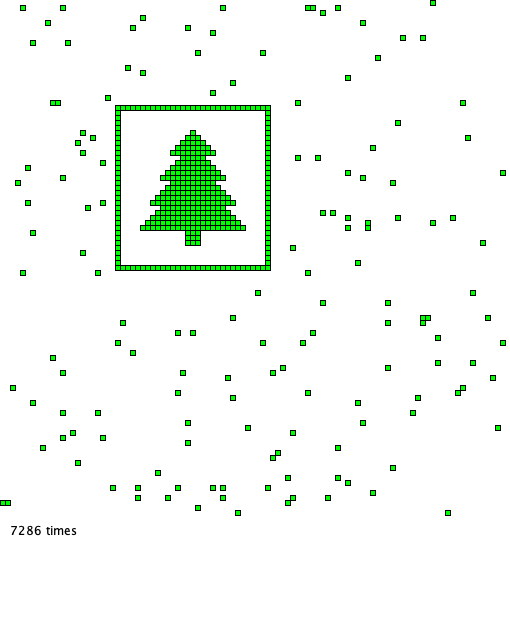

In [7]:
import kotlinx.coroutines.delay
import kotlinx.coroutines.runBlocking
import java.awt.Color
import java.awt.Rectangle
import java.awt.image.BufferedImage

fun draw(r: RobotGrid, message: String): BufferedImage {
    val scale = 5
    val sizeX = r.width * scale + scale
    val sizeY = r.height * scale + scale + 100
    return BufferedImage(sizeX, sizeY, BufferedImage.TYPE_INT_ARGB).apply {
        createGraphics().also {
            r.cells.forEach { pos, _ ->
                val shape = Rectangle(scale * pos.column, scale * pos.row, scale, scale)
                it.color = Color.GREEN
                it.fill(shape)
                it.color = Color.BLACK
                it.draw(shape)
            }
            it.drawString(message, 10, r.height * scale + 20)
        }
    }
}

val initial = RobotGrid(parse(puzzle.input()), 103, 101)
DISPLAY(draw(initial, "initial"), "robots")
var grid = initial
runBlocking {
    (1..(101 * 103)).forEach { iterations ->
        grid = grid.iterateOnce()
        if (grid.countRobots(0, 60, 0, 10) < 10 && grid.countRobots(0, 10, 0, 40) < 10) {
            delay(500)
            UPDATE_DISPLAY(draw(grid, "$iterations times"), "robots")
        }
    }
}
